In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [3]:
## Set Path Here before running the code
WORKING_DIRECTORY =  "/kaggle/input/alzheimer-mri-dataset/Dataset"

##  Name of classes
CLASSES = ['Mild_Demented',
           'Moderate_Demented',
           'Non_Demented',
           'Very_Mild_Demented']

In [4]:
X, y = [], []

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=(150, 150),batch_size=6400, shuffle=True)

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 6400 images belonging to 4 classes.


In [5]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 621), (1, 47), (2, 2239), (3, 1573)]
Validation	 [(0, 219), (1, 12), (2, 761), (3, 544)]
Test      	 [(0, 56), (1, 5), (2, 200), (3, 123)]


In [6]:
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))

#   class labels as per indices
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 896), (1, 64), (2, 3200), (3, 2240)]
Classes Names according to index:	 {'Mild_Demented': 0, 'Moderate_Demented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}


In [7]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4480, 150, 150, 3)
y_train shape: (4480, 4)
X_test shape: (384, 150, 150, 3)
y_test shape: (384, 4)


# LeNet

In [8]:
# Define the model architecture (LeNet)
model_lenet = Sequential([
    Conv2D(6, (5, 5), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes in the output layer
])

In [9]:
# Compile the model
model_lenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## LeNet Training...

In [10]:
# Train the model with reshaped labels
history_lenet = model_lenet.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
140/140 [==============================] - 10s 13ms/step - loss: 0.9780 - accuracy: 0.5304 - val_loss: 0.8255 - val_accuracy: 0.6120
Epoch 2/50
140/140 [==============================] - 1s 10ms/step - loss: 0.6014 - accuracy: 0.7493 - val_loss: 0.4290 - val_accuracy: 0.8307
Epoch 3/50
140/140 [==============================] - 1s 10ms/step - loss: 0.2788 - accuracy: 0.8982 - val_loss: 0.3648 - val_accuracy: 0.8542
Epoch 4/50
140/140 [==============================] - 1s 10ms/step - loss: 0.1230 - accuracy: 0.9565 - val_loss: 0.4950 - val_accuracy: 0.8438
Epoch 5/50
140/140 [==============================] - 1s 10ms/step - loss: 0.0666 - accuracy: 0.9788 - val_loss: 0.1931 - val_accuracy: 0.9453
Epoch 6/50
140/140 [==============================] - 1s 10ms/step - loss: 0.0180 - accuracy: 0.9962 - val_loss: 0.1267 - val_accuracy: 0.9688
Epoch 7/50
140/140 [==============================] - 1s 10ms/step - loss: 0.0209 - accuracy: 0.9935 - val_loss: 0.1111 - val_accuracy: 0.958

In [11]:
# Evaluate the model on the test set
test_loss_lenet, test_accuracy_lenet = model_lenet.evaluate(X_test, y_test)

12/12 [==============================] - 0s 6ms/step - loss: 0.1111 - accuracy: 0.9583


In [12]:
print(f"LeNet Test Accuracy: {test_accuracy_lenet}, Test Loss: {test_loss_lenet}")

LeNet Test Accuracy: 0.9583333134651184, Test Loss: 0.11109808832406998


# UNet

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, Input, concatenate, Flatten, Dense

In [14]:
# Define the model architecture (simplified U-Net)
def create_unet(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    flat = Flatten()(pool2)
    dense1 = Dense(128, activation='relu')(flat)
    outputs = Dense(4, activation='softmax')(dense1)  # 4 classes in the output layer

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [15]:
# Create U-Net model
model_unet = create_unet(input_shape=(150, 150, 3))

In [16]:
# Compile the model
model_unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## UNet Training

In [17]:
# Train the model
history_unet = model_unet.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
140/140 [==============================] - 5s 24ms/step - loss: 1.1668 - accuracy: 0.5078 - val_loss: 0.9387 - val_accuracy: 0.5345
Epoch 2/50
140/140 [==============================] - 2s 17ms/step - loss: 0.8414 - accuracy: 0.6185 - val_loss: 0.8995 - val_accuracy: 0.5684
Epoch 3/50
140/140 [==============================] - 2s 17ms/step - loss: 0.5444 - accuracy: 0.7717 - val_loss: 0.3924 - val_accuracy: 0.8405
Epoch 4/50
140/140 [==============================] - 2s 17ms/step - loss: 0.3328 - accuracy: 0.8683 - val_loss: 0.3181 - val_accuracy: 0.8763
Epoch 5/50
140/140 [==============================] - 2s 16ms/step - loss: 0.1810 - accuracy: 0.9337 - val_loss: 0.2353 - val_accuracy: 0.9049
Epoch 6/50
140/140 [==============================] - 2s 17ms/step - loss: 0.0893 - accuracy: 0.9703 - val_loss: 0.2229 - val_accuracy: 0.9264
Epoch 7/50
140/140 [==============================] - 2s 16ms/step - loss: 0.0845 - accuracy: 0.9650 - val_loss: 0.2295 - val_accuracy: 0.9251

In [18]:
# Evaluate the model on the test set
test_loss_unet, test_accuracy_unet = model_unet.evaluate(X_test, y_test)

12/12 [==============================] - 0s 7ms/step - loss: 0.2108 - accuracy: 0.9531


## UNet Test-Accuracy and Test-Loss

In [19]:
print(f"U-Net Test Accuracy: {test_accuracy_unet}, Test Loss: {test_loss_unet}")

U-Net Test Accuracy: 0.953125, Test Loss: 0.21081386506557465


# GoogLeNet

In [20]:
from tensorflow.keras.applications import InceptionV3

# Create InceptionV3 model
model_googlenet = InceptionV3(input_shape=(150, 150, 3), weights=None, classes=4)


In [21]:
# Compile the model
model_googlenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## GoogLe-Net Training...

In [22]:
# Training with EarlyStopping
history_googlenet = model_googlenet.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
140/140 [==============================] - 49s 99ms/step - loss: 1.0519 - accuracy: 0.5415 - val_loss: 1.0428 - val_accuracy: 0.5124
Epoch 2/50
140/140 [==============================] - 11s 81ms/step - loss: 0.8707 - accuracy: 0.6176 - val_loss: 28.4172 - val_accuracy: 0.1979
Epoch 3/50
140/140 [==============================] - 11s 81ms/step - loss: 0.9039 - accuracy: 0.5828 - val_loss: 1.5940 - val_accuracy: 0.3587
Epoch 4/50
140/140 [==============================] - 11s 82ms/step - loss: 0.9778 - accuracy: 0.5536 - val_loss: 4.9414 - val_accuracy: 0.5501


In [23]:
# Evaluate the model on the test set
test_loss_googlenet, test_accuracy_googlenet = model_googlenet.evaluate(X_test, y_test)

12/12 [==============================] - 0s 24ms/step - loss: 1.0634 - accuracy: 0.5026


In [24]:
print(f"GoogLeNet Test Accuracy: {test_accuracy_unet}, Test Loss: {test_loss_unet}")

GoogLeNet Test Accuracy: 0.953125, Test Loss: 0.21081386506557465


# EfficientNet

In [25]:
from tensorflow.keras.applications import EfficientNetB0

# Create EfficientNetB0 model
model_efficientnet = EfficientNetB0(input_shape=(150, 150, 3), weights=None, classes=4)

In [26]:
# Compile the model
model_efficientnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Efficient-Net Training...

In [27]:
# Training with EarlyStopping
history_efficientnet = model_efficientnet.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50


2024-01-04 01:21:45.542160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


140/140 [==============================] - 57s 138ms/step - loss: 2.4459 - accuracy: 0.4221 - val_loss: 1.1385 - val_accuracy: 0.4954
Epoch 2/50
140/140 [==============================] - 16s 114ms/step - loss: 1.4066 - accuracy: 0.5045 - val_loss: 1.0502 - val_accuracy: 0.4954
Epoch 3/50
140/140 [==============================] - 16s 114ms/step - loss: 1.1458 - accuracy: 0.5400 - val_loss: 1.0233 - val_accuracy: 0.5078
Epoch 4/50
140/140 [==============================] - 16s 113ms/step - loss: 1.0444 - accuracy: 0.5719 - val_loss: 1.1236 - val_accuracy: 0.5065
Epoch 5/50
140/140 [==============================] - 16s 114ms/step - loss: 0.9327 - accuracy: 0.6136 - val_loss: 14.2824 - val_accuracy: 0.4954
Epoch 6/50
140/140 [==============================] - 16s 115ms/step - loss: 0.7389 - accuracy: 0.6984 - val_loss: 0.9733 - val_accuracy: 0.6309
Epoch 7/50
140/140 [==============================] - 16s 115ms/step - loss: 0.4833 - accuracy: 0.8145 - val_loss: 0.5877 - val_accuracy: 0.

In [28]:
# Evaluate the model on the test set
test_loss_efficientnet, test_accuracy_efficientnet = model_efficientnet.evaluate(X_test, y_test)

12/12 [==============================] - 0s 25ms/step - loss: 0.2600 - accuracy: 0.9401


In [29]:
print(f"Efficient-Net Test Accuracy: {test_accuracy_efficientnet}, Test Loss: {test_loss_efficientnet}")

Efficient-Net Test Accuracy: 0.9401041865348816, Test Loss: 0.25998783111572266


# DenseNet

In [30]:
from tensorflow.keras.applications import DenseNet121

# Create DenseNet model
model_densenet = DenseNet121(input_shape=(150, 150, 3), weights=None, classes=4)


In [31]:
# Compile the model
model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## DenseNet Training...

In [32]:
# Training with EarlyStopping
history_densenet = model_densenet.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
140/140 [==============================] - 81s 133ms/step - loss: 0.9405 - accuracy: 0.5629 - val_loss: 3.1641 - val_accuracy: 0.4954
Epoch 2/50
140/140 [==============================] - 15s 110ms/step - loss: 0.8512 - accuracy: 0.6029 - val_loss: 4.1378 - val_accuracy: 0.5007
Epoch 3/50
140/140 [==============================] - 16s 112ms/step - loss: 0.7724 - accuracy: 0.6478 - val_loss: 1.0599 - val_accuracy: 0.5176
Epoch 4/50
140/140 [==============================] - 16s 112ms/step - loss: 0.6889 - accuracy: 0.7007 - val_loss: 1.0331 - val_accuracy: 0.5566
Epoch 5/50
140/140 [==============================] - 15s 110ms/step - loss: 0.5771 - accuracy: 0.7522 - val_loss: 1.1521 - val_accuracy: 0.5742
Epoch 6/50
140/140 [==============================] - 15s 110ms/step - loss: 0.4708 - accuracy: 0.8089 - val_loss: 1.6140 - val_accuracy: 0.5514
Epoch 7/50
140/140 [==============================] - 16s 112ms/step - loss: 0.3539 - accuracy: 0.8589 - val_loss: 1.1738 - val_ac

In [33]:
# Evaluate the model on the test set
test_loss_densenet, test_accuracy_densenet = model_densenet.evaluate(X_test, y_test)

12/12 [==============================] - 0s 31ms/step - loss: 1.0937 - accuracy: 0.5052


In [34]:
print(f"Dense-Net Test Accuracy: {test_accuracy_densenet}, Test Loss: {test_loss_densenet}")

Dense-Net Test Accuracy: 0.5052083134651184, Test Loss: 1.0936616659164429


# Results ploting

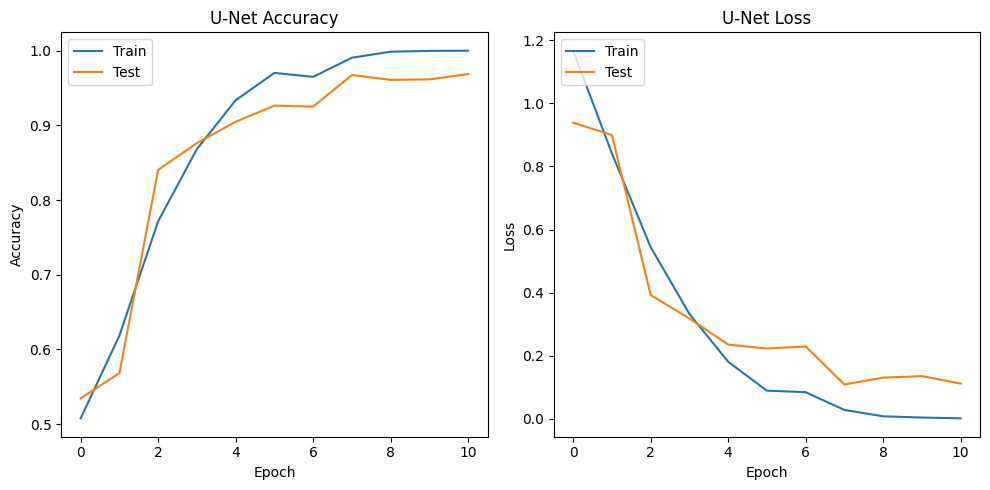

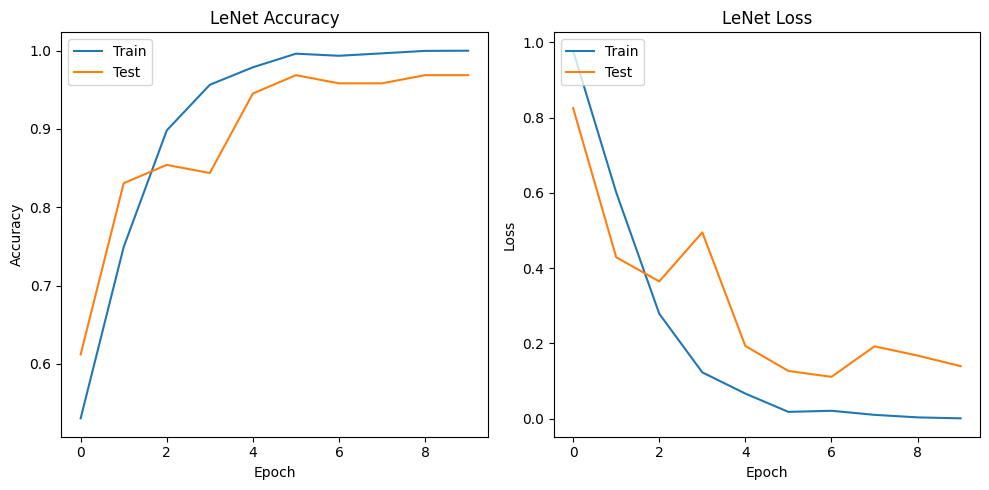

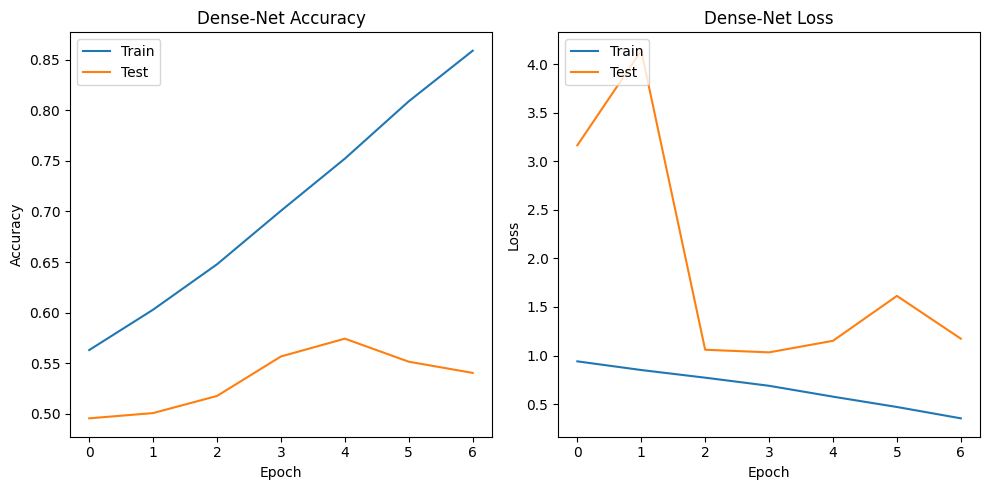

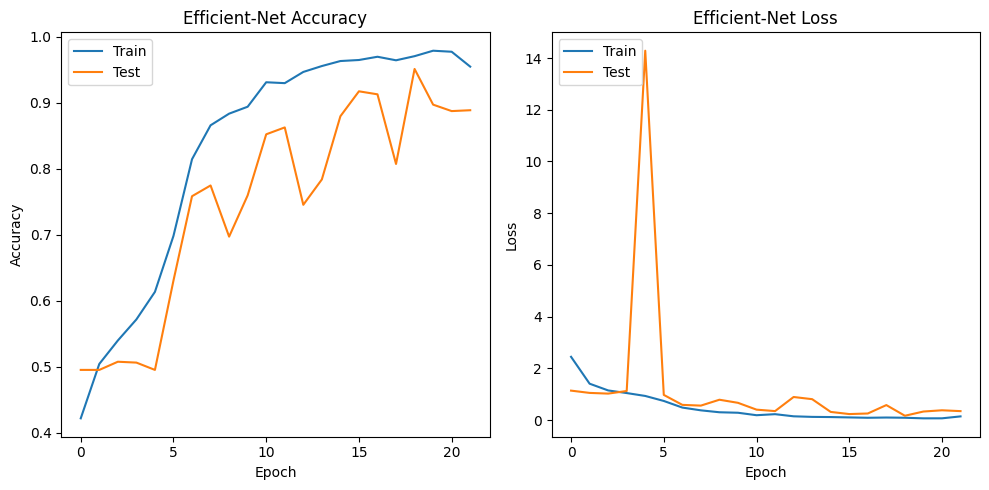

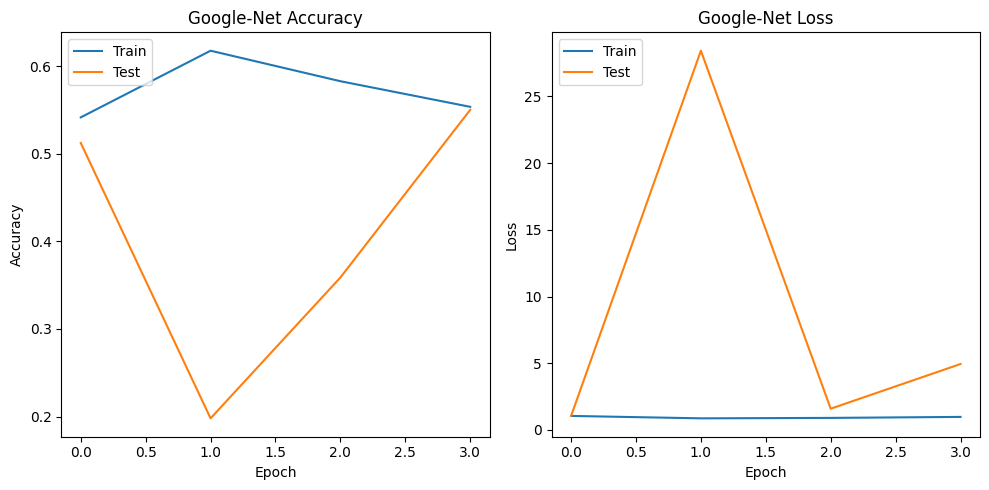

In [35]:
import matplotlib.pyplot as plt

# Define models and their histories (Assuming history_unet and history_lenet exist)
models = [history_unet, history_lenet, history_densenet, history_efficientnet, history_googlenet]  # Add more histories as needed

# Define model names for titles
model_names = ['U-Net', 'LeNet', 'Dense-Net', 'Efficient-Net', 'Google-Net']  # Add model names accordingly

# Plotting loop
for i, history in enumerate(models):
    plt.figure(figsize=(10, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_names[i]} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_names[i]} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f'{model_names[i]}_plot.png')
    plt.show()


# Results :

In [36]:
# Define models, their test accuracies, and test losses (assuming these lists are available)
models = ['UNet', 'LeNet', 'DenseNet', 'EfficientNet', 'GoogLeNet']  # Add your model names
test_accuracies = [test_accuracy_unet,
                   test_accuracy_lenet, 
                   test_accuracy_densenet,
                   test_accuracy_efficientnet,
                   test_accuracy_googlenet
                  ]  # Add test accuracies for each model
test_losses = [test_loss_unet,
                   test_loss_lenet, 
                   test_loss_densenet,
                   test_loss_efficientnet,
                   test_loss_googlenet]  # Add test losses for each model

In [37]:
# Create a DataFrame to store model information
import pandas as pd
data = {'Model': models, 'Test Accuracy': test_accuracies, 'Test Loss': test_losses}
df = pd.DataFrame(data)

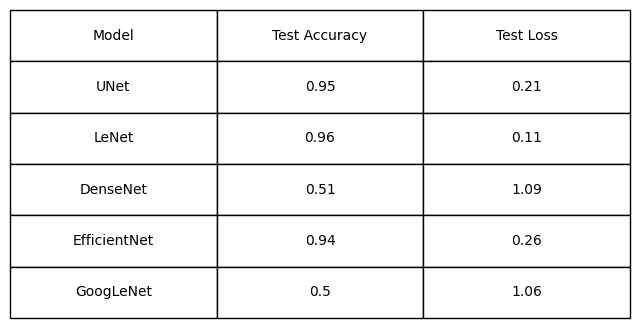

In [38]:
# Format the DataFrame to display values with two decimal points
df_formatted = df.round(2)

# Display the table with limited decimal points
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
ax.table(cellText=df_formatted.values, colLabels=df_formatted.columns, loc='center', cellLoc='center', bbox=[0, 0, 1, 1])
plt.show()